<a href="https://colab.research.google.com/github/GalRabin/botnet50/blob/main/botnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bottleneck Transformers for Visual Recognition (Link to BotNet50 [Article](https://arxiv.org/pdf/2101.11605v1.pdf))

## BotNet50 implementation

### Dependencies

In [49]:
!python -V

Python 3.6.9


In [48]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.6
dlib==19.18.0
dm-tree==0.1.5
docopt

In [47]:
!pip install einops

### Imports

In [41]:
import torch
from torch import nn, einsum

from einops import rearrange
from torchvision.models import resnet50

### Helper functions

In [42]:
def pair(x):
    return (x, x) if not isinstance(x, tuple) else x


def expand_dim(t, dim, k):
    t = t.unsqueeze(dim=dim)
    expand_shape = [-1] * len(t.shape)
    expand_shape[dim] = k
    return t.expand(*expand_shape)


def rel_to_abs(x):
    b, h, l, _, device, dtype = *x.shape, x.device, x.dtype
    dd = {'device': device, 'dtype': dtype}
    col_pad = torch.zeros((b, h, l, 1), **dd)
    x = torch.cat((x, col_pad), dim=3)
    flat_x = rearrange(x, 'b h l c -> b h (l c)')
    flat_pad = torch.zeros((b, h, l - 1), **dd)
    flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)
    final_x = flat_x_padded.reshape(b, h, l + 1, 2 * l - 1)
    final_x = final_x[:, :, :l, (l - 1):]
    return final_x


def relative_logits_1d(q, rel_k):
    b, heads, h, w, dim = q.shape
    logits = einsum('b h x y d, r d -> b h x y r', q, rel_k)
    logits = rearrange(logits, 'b h x y r -> b (h x) y r')
    logits = rel_to_abs(logits)
    logits = logits.reshape(b, heads, h, w, w)
    logits = expand_dim(logits, dim=3, k=h)
    return logits


# positional embeddings

class AbsPosEmb(nn.Module):
    def __init__(
            self,
            fmap_size,
            dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.height = nn.Parameter(torch.randn(height, dim_head) * scale)
        self.width = nn.Parameter(torch.randn(width, dim_head) * scale)

    def forward(self, q):
        emb = rearrange(self.height, 'h d -> h () d') + rearrange(self.width, 'w d -> () w d')
        emb = rearrange(emb, ' h w d -> (h w) d')
        logits = einsum('b h i d, j d -> b h i j', q, emb)
        return logits


class RelPosEmb(nn.Module):
    def __init__(
            self,
            fmap_size,
            dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.fmap_size = fmap_size
        self.rel_height = nn.Parameter(torch.randn(height * 2 - 1, dim_head) * scale)
        self.rel_width = nn.Parameter(torch.randn(width * 2 - 1, dim_head) * scale)

    def forward(self, q):
        h, w = self.fmap_size

        q = rearrange(q, 'b h (x y) d -> b h x y d', x=h, y=w)
        rel_logits_w = relative_logits_1d(q, self.rel_width)
        rel_logits_w = rearrange(rel_logits_w, 'b h x i y j-> b h (x y) (i j)')

        q = rearrange(q, 'b h x y d -> b h y x d')
        rel_logits_h = relative_logits_1d(q, self.rel_height)
        rel_logits_h = rearrange(rel_logits_h, 'b h x i y j -> b h (y x) (j i)')
        return rel_logits_w + rel_logits_h

### Attention

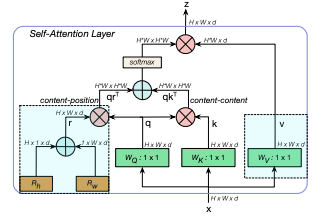

In [43]:
#####################
##### Attention #####
#####################

class Attention(nn.Module):
    def __init__(
            self,
            *,
            dim,
            fmap_size,
            heads=4,
            dim_head=128,
            rel_pos_emb=False
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_qkv = nn.Conv2d(dim, inner_dim * 3, 1, bias=False)

        rel_pos_class = AbsPosEmb if not rel_pos_emb else RelPosEmb
        self.pos_emb = rel_pos_class(fmap_size, dim_head)

    def forward(self, fmap):
        heads, b, c, h, w = self.heads, *fmap.shape

        q, k, v = self.to_qkv(fmap).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h=heads), (q, k, v))

        q *= self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        sim += self.pos_emb(q)

        attn = sim.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return out

### Bottleneck transformer

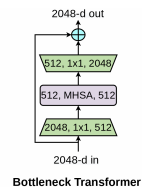

In [44]:
class BottleBlock(nn.Module):
    def __init__(
            self,
            *,
            dim,
            fmap_size,
            dim_out,
            proj_factor,
            downsample,
            heads=4,
            dim_head=128,
            rel_pos_emb=False,
            activation=nn.ReLU()
    ):
        super().__init__()

        # shortcut

        if dim != dim_out or downsample:
            kernel_size, stride, padding = (3, 2, 1) if downsample else (1, 1, 0)

            self.shortcut = nn.Sequential(
                nn.Conv2d(dim, dim_out, kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(dim_out),
                activation
            )
        else:
            self.shortcut = nn.Identity()

        # contraction and expansion

        attn_dim_in = dim_out // proj_factor
        attn_dim_out = heads * dim_head

        self.net = nn.Sequential(
            nn.Conv2d(dim, attn_dim_in, 1, bias=False),
            nn.BatchNorm2d(attn_dim_in),
            activation,
            Attention(
                dim=attn_dim_in,
                fmap_size=fmap_size,
                heads=heads,
                dim_head=dim_head,
                rel_pos_emb=rel_pos_emb
            ),
            nn.AvgPool2d((2, 2)) if downsample else nn.Identity(),
            nn.BatchNorm2d(attn_dim_out),
            activation,
            nn.Conv2d(attn_dim_out, dim_out, 1, bias=False),
            nn.BatchNorm2d(dim_out)
        )

        # init last batch norm gamma to zero

        nn.init.zeros_(self.net[-1].weight)

        # final activation

        self.activation = activation

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.net(x)
        x += shortcut
        return self.activation(x)

### BottleStack

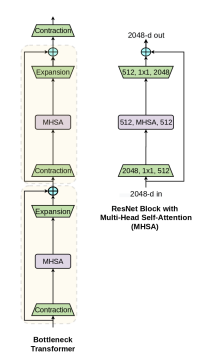

In [45]:
class BottleStack(nn.Module):
    def __init__(
            self,
            *,
            dim,
            fmap_size,
            dim_out=2048,
            proj_factor=4,
            num_layers=3,
            heads=4,
            dim_head=128,
            downsample=True,
            rel_pos_emb=False,
            activation=nn.ReLU()
    ):
        super().__init__()
        fmap_size = pair(fmap_size)

        self.dim = dim
        self.fmap_size = fmap_size

        layers = []

        for i in range(num_layers):
            is_first = i == 0
            dim = (dim if is_first else dim_out)
            layer_downsample = is_first and downsample

            fmap_divisor = (2 if downsample and not is_first else 1)
            layer_fmap_size = tuple(map(lambda t: t // fmap_divisor, fmap_size))

            layers.append(BottleBlock(
                dim=dim,
                fmap_size=layer_fmap_size,
                dim_out=dim_out,
                proj_factor=proj_factor,
                heads=heads,
                dim_head=dim_head,
                downsample=layer_downsample,
                rel_pos_emb=rel_pos_emb,
                activation=activation
            ))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        _, c, h, w = x.shape
        assert c == self.dim, f'channels of feature map {c} must match channels given at init {self.dim}'
        assert h == self.fmap_size[0] and w == self.fmap_size[
            1], f'height and width ({h} {w}) of feature map must match the fmap_size given at init {self.fmap_size}'
        return self.net(x)

### BotNet50

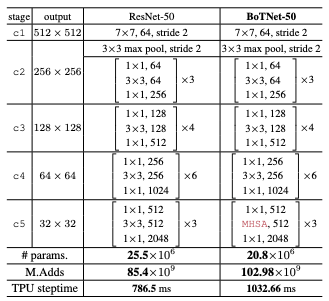

In [46]:
class BotNet50(nn.Module):
    def __init__(self):
        super(BotNet50, self).__init__()
        layer = BottleStack(
            dim=256,
            fmap_size=56,  # set specifically for imagenet's 224 x 224
            dim_out=2048,
            proj_factor=4,
            downsample=True,
            heads=4,
            dim_head=128,
            rel_pos_emb=True,
            activation=nn.ReLU()
        )

        resnet = resnet50()

        # model surgery

        backbone = list(resnet.children())

        self._model = nn.Sequential(
            *backbone[:7],
            layer,
            *backbone[8:],
        )

    def forward(self, img):
        return self._model(img)

## BotNet50 train

### Data load

### Train

## BotNet50 test

### Data load

### Evaluation